In [14]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

In [2]:
with open('../mappings/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('../mappings/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [3]:
def cleanStringofUTF(string):
    cleaned = string.encode('utf-8').replace('\xe8','e').replace('\xf6','o')
    return cleaned

def enrichdrugs(chem_dict , drugs):
    diabetes_drug_words = [drugs[k]['name'].lower() for k in drugs]
    for drug in chem_dict:
        Name = chem_dict[drug]['name'].replace('(','').replace(')','')
        slot1 = Name.lower().split('/')
        slot2 = Name.lower().split(' ')
        slot3 = Name.lower().split(' & ')
        common1 = set(diabetes_drug_words).intersection(slot1)
        common2 = set(diabetes_drug_words).intersection(slot2)
        common3 = set(diabetes_drug_words).intersection(slot3)
        
        if len(common1) > 0 or len(common2) > 0 or len(common3) > 0:
#             print common1 , common2 , common3
            drugs[chem_dict[drug]['code']] = {'disease':'' , 'disease_given_drug':0.0 , 'matched_disease':'', 'name':chem_dict[drug]['name'].strip() }

            
            
def makeChemDict(BNF_Chem):
    chem_dict = {}
    for index, row in BNF_Chem.iterrows():
        chem_dict[row['UNII_drugbank']] = {}
        chem_dict[row['UNII_drugbank']]['name'] = row['NAME']
        chem_dict[row['UNII_drugbank']]['code'] = row['BNF_code']
    return chem_dict
    
def getDrugCategory(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Categories']) > 0:
            for cat in drugbankDict[k]['Categories']:
                matched_memo = []
                catString = cat.values()[0]#.split('\u2014')[-1]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:# == len(categorylist):
                        allMatched.append(k)
#                         print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return list(set(allMatched)) , drugs


def getDrugforDiseaseDrugbank(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Associations']) > 0:
            for cat in drugbankDict[k]['Associations']:
                matched_memo = []
                catString = cat.values()[0]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:
                        allMatched.append(k)
#                         print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return  allMatched , drugs


def findDrugsForDisease(Graph, Disease, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Disease.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Disease.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'symptom':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_disease'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['disease'] = Disease
    enrichdrugs(chem_dict,drugs)
    return drugs


def generateConfidence(drugs,Graph):
    shared = []
    All = []
    denom = max(Graph.degree().values())
    for d in drugs:
        name = drugs[d]['name']
        for e in Graph.edges(data=True):
            if Graph.node[e[0]]['type'] == 'symptom':
                if e[1] == name:
                    shared.append(Graph.degree()[e[1]]-1)
                else:
                    continue
            else:
                
                if e[0] == name:
                    shared.append(Graph.degree()[e[0]]-1)
                else:
                    continue
#     shared = [float(k) for k in shared]
    num = [k for k in shared if k > 1]

    return float(len(num)+1.0)/float(len(shared)+1.0)
#     return float(len(num))/float(len(shared)) * 10.0
#     return len(num)
                
                
def findDrugsForCategory(Graph, Cat, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Cat.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Cat.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'category':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            print Graph.node[drugNode]['Id']
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_cat'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['category'] = Cat
    enrichdrugs(chem_dict,drugs)
    return drugs


In [4]:
files = glob.glob('../../BL_Work/openPrescribe/serialized/*.gz')
print(files)

['../../BL_Work/openPrescribe/serialized/201810.gz', '../../BL_Work/openPrescribe/serialized/201710.gz', '../../BL_Work/openPrescribe/serialized/201203.gz', '../../BL_Work/openPrescribe/serialized/201110.gz', '../../BL_Work/openPrescribe/serialized/202010.gz', '../../BL_Work/openPrescribe/serialized/201804.gz', '../../BL_Work/openPrescribe/serialized/201911.gz', '../../BL_Work/openPrescribe/serialized/201308.gz', '../../BL_Work/openPrescribe/serialized/201708.gz', '../../BL_Work/openPrescribe/serialized/202005.gz', '../../BL_Work/openPrescribe/serialized/201211.gz', '../../BL_Work/openPrescribe/serialized/201707.gz', '../../BL_Work/openPrescribe/serialized/201803.gz', '../../BL_Work/openPrescribe/serialized/201410.gz', '../../BL_Work/openPrescribe/serialized/201301.gz', '../../BL_Work/openPrescribe/serialized/201201.gz', '../../BL_Work/openPrescribe/serialized/201409.gz', '../../BL_Work/openPrescribe/serialized/201812.gz', '../../BL_Work/openPrescribe/serialized/201603.gz', '../../BL_W

In [5]:
chem = pd.read_csv('../mappings/CHEM_MASTER_MAP.csv')
len(chem)

# chem = chem.dropna()

matched = chem[chem['UNII_drugbank']!='[]']

matchedMap = {}
for index,row in matched.iterrows():
    if row['UNII_drugbank'] not in matchedMap:
         matchedMap[row['UNII_drugbank']] = []
    matchedMap[row['UNII_drugbank']].append(row['BNF_code'])

diseases = [
 "anxiety",
 "rheumatoid",
 "osteoporosis",
 "kidney disease",
 "depression",
 "diabetes",
 "stroke",
 "epilepsy",
 "heart failure",
 "atrial fibrilation",
 "hypertension",
 "chronic obstructive pulmonary disease", 
 "dementia",
 "obesity",
 "coronary artery disease"
]

DiseaseDrugs = {}
for d in diseases:
    drugs = findDrugsForDisease(drug_association_graph,d ,chem)
#     _ , drugs = getDrugforDiseaseDrugbank([d] ,chem,drugbank_dict)
    for drug in drugs:
        DiseaseDrugs[drug] = {}
        DiseaseDrugs[drug]['chemName'] = drugs[drug]['name']
        DiseaseDrugs[drug]['disease'] = d

In [6]:
DiseaseDrugs

{'0103010S0': {'chemName': 'Ranitidine Bismuth Citrate',
  'disease': 'hypertension'},
 '0103010T0': {'chemName': 'Ranitidine Hydrochloride',
  'disease': 'hypertension'},
 '0105010E0': {'chemName': 'Sulfasalazine', 'disease': 'rheumatoid'},
 '0105020A0': {'chemName': 'Budesonide',
  'disease': 'chronic obstructive pulmonary disease'},
 '0107010AA': {'chemName': 'Diltiazem Hydrochloride',
  'disease': 'hypertension'},
 '0107040A0': {'chemName': 'Glyceryl Trinitrate', 'disease': 'hypertension'},
 '0201010F0': {'chemName': 'Digoxin', 'disease': 'heart failure'},
 '0201020M0': {'chemName': 'Milrinone Lactate', 'disease': 'heart failure'},
 '0202010B0': {'chemName': 'Bendroflumethiazide', 'disease': 'hypertension'},
 '0202010D0': {'chemName': 'Chlorothiazide', 'disease': 'hypertension'},
 '0202010L0': {'chemName': 'Hydrochlorothiazide', 'disease': 'hypertension'},
 '0202010P0': {'chemName': 'Indapamide', 'disease': 'hypertension'},
 '0202010T0': {'chemName': 'Methyclothiazide', 'disease': 

In [9]:
disease_drug_map = {}
for k in DiseaseDrugs:
    if DiseaseDrugs[k]['disease'] not in disease_drug_map:
        disease_drug_map[DiseaseDrugs[k]['disease']] = []
    disease_drug_map[DiseaseDrugs[k]['disease']].append(k)

In [10]:
# disease_drug_map

In [11]:
LSOA_dist = json.load(open('../mappings/GP_LSOA_PATIENTSDIST.json','rb'))

In [12]:
LSOA_dist_2021 = json.load(open('mappings/GP_LSOA_PATIENTSDIST_2021.json','rb'))

In [187]:
LSOA_dist['A81001']['E01033477']

0.11856400566839868

In [13]:
LSOA_dist_2021['A81001']['E01033477']

0.1600780868716447

In [14]:
# LSOA_dist_new = pd.read_csv('mappings/gp-reg-pat-prac-lsoa-all.csv')

In [15]:
# LSOA_dist_new.head()

In [16]:
# LSOA_dist_2021 = {}
# for name , group in LSOA_dist_new.groupby('PRACTICE_CODE'):
#     LSOA_dist_2021[name] = {}
#     total = sum(group['Number of Patients'])
#     for index , row in group.iterrows():
#         LSOA_dist_2021[name][row['LSOA_CODE']] = float(row['Number of Patients'])/float(total)
    
        

In [17]:
# json.dump(LSOA_dist_2021 , open('mappings/GP_LSOA_PATIENTSDIST_2021.json','w'))

In [18]:
%store -r taxonomyDict

In [19]:
# json.dump(taxonomyDict, open('../mappings/taxomomy_dict.json','w'))

In [20]:
%store -r cityMap

In [21]:
# json.dump(cityMap, open('../mappings/City_map_dict.json','w'))

In [22]:
ward_pop = pd.read_csv('../mappings/ward_pop.csv')

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
population = {}
for index, row in ward_pop.iterrows():
    population[row['Ward Code 1']] = float(row['All Ages'].replace(',',''))

In [24]:
df_city = pd.read_csv('../mappings/lower_layer_super_output_area_2011_to_major_towns_and_cities_december_2015_lookup_in_england_and_wales.csv')

In [33]:
df_city.head()

,LSOA11CD,LSOA11NM,TCITY15CD,TCITY15NM,FID
0,E01002351,Havering 016C,J01000055,London,2001
1,E01002352,Havering 016D,J01000055,London,2002
2,E01002100,Haringey 008B,J01000055,London,2003
3,E01002301,Havering 003A,J01000055,London,2004
4,E01002353,Havering 013B,J01000055,London,2005


In [25]:
cityMap = {}
for name , group in df_city.groupby('TCITY15NM'):
        cityMap[name] = list(group['LSOA11CD'])

In [26]:
LSOA_survey_takers = json.load(open('../mappings/LSOA_suvery_pop.json'))

In [27]:
disease_drugs = json.load(open("../mappings/Disease_Drug_DrugBank.json",'rb'))

In [28]:
drugbank_dict = json.load(open('../mappings/Drugbank_drugs_data.json','rb'))

In [29]:
cityMap

{'Barnsley': ['E01007344',
  'E01007355',
  'E01007356',
  'E01007357',
  'E01007358',
  'E01007359',
  'E01007360',
  'E01007361',
  'E01007362',
  'E01007363',
  'E01007379',
  'E01007380',
  'E01007381',
  'E01007386',
  'E01007387',
  'E01007317',
  'E01007318',
  'E01007319',
  'E01007320',
  'E01007321',
  'E01007322',
  'E01007323',
  'E01007324',
  'E01007325',
  'E01007326',
  'E01007327',
  'E01007334',
  'E01007335',
  'E01007336',
  'E01007337',
  'E01007338',
  'E01007339',
  'E01007340',
  'E01007446',
  'E01007400',
  'E01007402',
  'E01007403',
  'E01007404',
  'E01007405',
  'E01007406',
  'E01007408',
  'E01007409',
  'E01007410',
  'E01007411',
  'E01007413',
  'E01007414',
  'E01007415',
  'E01007416',
  'E01007417',
  'E01007437',
  'E01007441',
  'E01007442',
  'E01007443',
  'E01007444',
  'E01007445',
  'E01032550',
  'E01032551'],
 'Basildon': ['E01021323',
  'E01021324',
  'E01021325',
  'E01021326',
  'E01021327',
  'E01021273',
  'E01021328',
  'E01021274',


In [30]:
IMD_df = pd.read_csv('../../BL_Work/File_7_ID_2015_All_ranks__deciles_and_scores_for_the_Indices_of_Deprivation__and_population_denominators.csv')

In [32]:
IMD_df.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2013),Local Authority District name (2013),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Indoors Sub-domain Rank (where 1 is most deprived),Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Total population: mid 2012 (excluding prisoners),Dependent Children aged 0-15: mid 2012 (excluding prisoners),Population aged 16-59: mid 2012 (excluding prisoners),Older population aged 60 and over: mid 2012 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)
0,E01031349,Adur 001A,E07000223,Adur,12.389,21352,7,0.096,18992,6,...,20379,7,0.312,11318,4,1318,206,694,418,702.75
1,E01031350,Adur 001B,E07000223,Adur,28.619,8864,3,0.187,9233,3,...,16285,5,0.234,12445,4,1212,232,712,268,720.75
2,E01031351,Adur 001C,E07000223,Adur,11.713,22143,7,0.065,24539,8,...,25054,8,0.208,12820,4,1577,290,829,458,838.25
3,E01031352,Adur 001D,E07000223,Adur,16.446,17252,6,0.117,16087,5,...,24455,8,0.109,14350,5,1453,233,739,481,748.25
4,E01031370,Adur 001E,E07000223,Adur,18.265,15643,5,0.102,17918,6,...,20214,7,0.321,11202,4,1443,306,799,338,795.50


In [34]:
LSOA_pop = {}
LSOA_IMD = {}
for index, row in IMD_df.iterrows():
    LSOA_pop[row['LSOA code (2011)']] = row['Total population: mid 2012 (excluding prisoners)']
    LSOA_IMD[row['LSOA code (2011)']] = row['Index of Multiple Deprivation (IMD) Score']

In [35]:
cityPop = {}
city_IMD = {}
city_survey_pop = {}
for k in cityMap:
    pop = 0
    surveypop = 0
    IMD = []
    for j in cityMap[k]:
        try:
            pop += LSOA_pop[j]
            surveypop += LSOA_survey_takers[j]
            IMD.append(LSOA_IMD[j])
        except:
            print("could not find LSOA",j)
    city_IMD[k] = {}
    if pop > 0:
        cityPop[k] = pop
        city_survey_pop[k] = surveypop
        city_IMD[k]['median_IMD'] = np.median(IMD)
        city_IMD[k]['mean_IMD'] = np.mean(IMD)

('could not find LSOA', 'W01001912')
('could not find LSOA', 'W01001913')
('could not find LSOA', 'W01001600')
('could not find LSOA', 'W01001651')
('could not find LSOA', 'W01001601')
('could not find LSOA', 'W01001652')
('could not find LSOA', 'W01001602')
('could not find LSOA', 'W01001653')
('could not find LSOA', 'W01001654')
('could not find LSOA', 'W01001603')
('could not find LSOA', 'W01001604')
('could not find LSOA', 'W01001655')
('could not find LSOA', 'W01001605')
('could not find LSOA', 'W01001606')
('could not find LSOA', 'W01001607')
('could not find LSOA', 'W01001659')
('could not find LSOA', 'W01001608')
('could not find LSOA', 'W01001660')
('could not find LSOA', 'W01001609')
('could not find LSOA', 'W01001661')
('could not find LSOA', 'W01001610')
('could not find LSOA', 'W01001662')
('could not find LSOA', 'W01001611')
('could not find LSOA', 'W01001663')
('could not find LSOA', 'W01001612')
('could not find LSOA', 'W01001664')
('could not find LSOA', 'W01001613')
(

In [36]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='City_pre_postcovid.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [48]:
def calculateTemporalMetrics(all_presc , cityPop , old = True):
    LSOA_dosage = {}
    LSOA_costs = {}
    fail = 0.0
    LSOA_map = {}
    if old:
        dosageField = '8'
        costField = '7'
        practiceField = '2'
        LSOA_map = LSOA_dist
    else:
        dosageField = 'TOTAL_QUANTITY'
        costField = 'ACTUAL_COST'
        practiceField = 'PRACTICE_CODE'
        LSOA_map = LSOA_dist_2021

    for name, group in all_presc.groupby(practiceField):
        total_dosage = np.sum(group[dosageField])
        total_cost = np.sum(group[costField])
        if name in LSOA_map:        
            for k in LSOA_map[name]:
                if k not in LSOA_dosage:
                    LSOA_dosage[k] = 0.0
                    LSOA_costs[k] = 0.0
                LSOA_dosage[k]+= float(total_dosage)*float(LSOA_map[name][k])
                LSOA_costs[k]+= float(total_cost)*float(LSOA_map[name][k])

    borough_dosage_UK = {}
    borough_cost_UK = {}
    
#calculate city level savings
    for k in cityMap:
        logging.debug("Working with city  " + k)
        try:
            borough_dosages= np.sum([LSOA_dosage[w] for w in cityMap[k] if not np.isnan(LSOA_dosage[w] and w in LSOA_dosage)])
            borough_costs= np.sum([LSOA_costs[w] for w in cityMap[k] if not np.isnan(LSOA_costs[w] and w in LSOA_costs)])

            pop = cityPop[k]
            borough_dosage_UK[k] = (float(borough_dosages)/float(pop))*1000.0
            borough_cost_UK[k] = (float(borough_costs)/float(pop))*1000.0

        except:
            print("Failed something at "+k)
            logging.debug("Failed something at "+k)
            fail+=1
    
    return  borough_dosage_UK , borough_cost_UK

In [51]:
# monthly_borough_dosage = {}
# monthly_borough_costs = {}

monthly_borough_dosage_new = {}
monthly_borough_costs_new = {}

In [52]:
files.sort()

In [66]:
files[53:101]

['../../BL_Work/openPrescribe/serialized/201501.gz',
 '../../BL_Work/openPrescribe/serialized/201502.gz',
 '../../BL_Work/openPrescribe/serialized/201503.gz',
 '../../BL_Work/openPrescribe/serialized/201504.gz',
 '../../BL_Work/openPrescribe/serialized/201505.gz',
 '../../BL_Work/openPrescribe/serialized/201506.gz',
 '../../BL_Work/openPrescribe/serialized/201507.gz',
 '../../BL_Work/openPrescribe/serialized/201508.gz',
 '../../BL_Work/openPrescribe/serialized/201509.gz',
 '../../BL_Work/openPrescribe/serialized/201510.gz',
 '../../BL_Work/openPrescribe/serialized/201511.gz',
 '../../BL_Work/openPrescribe/serialized/201512.gz',
 '../../BL_Work/openPrescribe/serialized/201601.gz',
 '../../BL_Work/openPrescribe/serialized/201602.gz',
 '../../BL_Work/openPrescribe/serialized/201603.gz',
 '../../BL_Work/openPrescribe/serialized/201604.gz',
 '../../BL_Work/openPrescribe/serialized/201605.gz',
 '../../BL_Work/openPrescribe/serialized/201606.gz',
 '../../BL_Work/openPrescribe/serialized/20160

In [53]:
files[107:]

['../../BL_Work/openPrescribe/serialized/201907.gz',
 '../../BL_Work/openPrescribe/serialized/201908.gz',
 '../../BL_Work/openPrescribe/serialized/201909.gz',
 '../../BL_Work/openPrescribe/serialized/201910.gz',
 '../../BL_Work/openPrescribe/serialized/201911.gz',
 '../../BL_Work/openPrescribe/serialized/201912.gz',
 '../../BL_Work/openPrescribe/serialized/202001.gz',
 '../../BL_Work/openPrescribe/serialized/202002.gz',
 '../../BL_Work/openPrescribe/serialized/202003.gz',
 '../../BL_Work/openPrescribe/serialized/202004.gz',
 '../../BL_Work/openPrescribe/serialized/202005.gz',
 '../../BL_Work/openPrescribe/serialized/202006.gz',
 '../../BL_Work/openPrescribe/serialized/202007.gz',
 '../../BL_Work/openPrescribe/serialized/202008.gz',
 '../../BL_Work/openPrescribe/serialized/202009.gz',
 '../../BL_Work/openPrescribe/serialized/202010.gz',
 '../../BL_Work/openPrescribe/serialized/202011.gz',
 '../../BL_Work/openPrescribe/serialized/202012.gz',
 '../../BL_Work/openPrescribe/serialized/20210

In [67]:
for f in tqdm(files[53:101]):
    month = f.split('/')[-1].split('.')[0]
    logging.debug("Working with month  " + month)
    if int(month) > 201906:
        old = False
    else:
        old = True
    
    monthly_borough_dosage_new[month] = {}
    monthly_borough_costs_new[month] = {}
    pdp = pd.read_csv(f,compression='gzip')
    for disease in tqdm(disease_drug_map):
        print "Working with disease  " + disease
        logging.debug("Working with disease  " + disease)
        monthly_borough_dosage_new[month][disease] = {}
        monthly_borough_costs_new[month][disease] = {}
        drugs = disease_drug_map[disease]
        opioids = pdp.loc[pdp['16'].isin(drugs)] #Original opioids

        monthly_borough_dosage_new[month][disease] , monthly_borough_costs_new[month][disease] = calculateTemporalMetrics(opioids, cityPop, old)
   

  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.79s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:29,  7.50s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:21,  7.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:52,  5.26s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:54,  6.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:52,  6.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:45<00:48,  6.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:43,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:36,  7.24s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:00<00:20,  5.13s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:17,  5.77s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:15<00:12,  6.35s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:23<00:06,  6.79s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



  2%|▏         | 1/48 [02:20<1:50:20, 140.86s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:39,  7.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:29,  7.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:23,  7.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.35s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Failed something at Southend-on-Sea
Fail


 36%|███▌      | 5/14 [00:30<00:55,  6.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:52,  6.59s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:49,  7.03s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:43,  7.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:37,  7.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.26s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:09<00:17,  5.91s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:12,  6.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.82s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



  4%|▍         | 2/48 [04:40<1:47:42, 140.49s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:35,  7.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:27,  7.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:19,  7.22s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:51,  5.12s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:52,  5.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:49,  6.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:43<00:45,  6.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:50<00:40,  6.68s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:34,  6.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:58<00:19,  4.95s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:17,  5.67s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:13<00:12,  6.29s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:21<00:06,  6.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



  6%|▋         | 3/48 [06:57<1:44:32, 139.39s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.83s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:32,  7.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:25,  7.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.48s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:55,  6.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:52,  6.54s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:49,  7.00s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:44,  7.42s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:37,  7.51s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.32s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:17,  5.98s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:13,  6.75s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:27<00:07,  7.17s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



  8%|▊         | 4/48 [09:20<1:43:01, 140.49s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:08<01:44,  8.01s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:35,  7.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:26,  7.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.57s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.31s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.72s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:49,  7.10s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:44,  7.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:36,  7.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:20,  5.13s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:16,  5.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:12,  6.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:24<00:06,  6.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 10%|█         | 5/48 [11:41<1:40:52, 140.75s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.84s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:31,  7.61s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:22,  7.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.31s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:52,  5.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:48,  6.06s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:42<00:43,  6.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:49<00:37,  6.31s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:56<00:33,  6.65s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:56<00:18,  4.74s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:04<00:16,  5.59s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:12<00:12,  6.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:20<00:06,  6.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 12%|█▎        | 6/48 [13:57<1:37:32, 139.34s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:43,  7.93s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:34,  7.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:26,  7.87s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.59s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:56<00:45,  7.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:04<00:38,  7.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:04<00:21,  5.41s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:11<00:17,  5.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:12,  6.35s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 15%|█▍        | 7/48 [16:19<1:35:45, 140.12s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.83s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:32,  7.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.45s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.09s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:50,  6.32s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:45,  6.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:40,  6.70s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:33,  6.79s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:58<00:19,  4.81s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:16,  5.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:12<00:11,  5.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:20<00:06,  6.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 17%|█▋        | 8/48 [18:34<1:32:25, 138.65s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:39,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:30,  7.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.42s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:50,  6.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:45,  6.54s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:39,  6.67s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:33,  6.72s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:58<00:19,  4.77s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:16,  5.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:12<00:11,  5.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:20<00:06,  6.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 19%|█▉        | 9/48 [20:51<1:29:39, 137.95s/it]A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:32,  7.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:24,  7.72s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.47s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:55,  6.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:52,  6.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:48,  6.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:43,  7.27s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:37,  7.48s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.31s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:18,  6.12s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:19<00:13,  6.75s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:27<00:07,  7.14s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 21%|██        | 10/48 [23:13<1:28:06, 139.11s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:35,  7.31s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:13<01:25,  7.11s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:18,  7.11s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:50,  5.04s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:53,  5.89s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:51,  6.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:48,  6.90s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:52<00:42,  7.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:59<00:36,  7.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:00<00:20,  5.12s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:07<00:17,  5.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:14<00:12,  6.19s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:21<00:06,  6.45s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 23%|██▎       | 11/48 [25:30<1:25:27, 138.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.89s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:32,  7.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:54,  5.43s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:54,  6.75s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:49,  7.14s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:44,  7.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:37,  7.42s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.26s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:18,  6.00s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:13,  6.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:26<00:07,  7.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 25%|██▌       | 12/48 [27:53<1:24:01, 140.05s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.91s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.81s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:25,  7.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.52s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.15s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:44,  7.44s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:03<00:37,  7.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:03<00:21,  5.35s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:17,  5.93s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:12,  6.36s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:26<00:06,  6.82s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 27%|██▋       | 13/48 [30:15<1:21:56, 140.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:37,  7.51s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:27,  7.32s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:21,  7.38s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:52,  5.24s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.05s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:52,  6.54s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:45<00:48,  6.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:43,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:36,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:00<00:20,  5.11s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:07<00:16,  5.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:14<00:12,  6.08s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:22<00:06,  6.61s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 29%|██▉       | 14/48 [32:34<1:19:23, 140.11s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:43,  7.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:54,  5.43s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.02s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:50,  6.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:45,  6.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:40,  6.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:33,  6.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:58<00:19,  4.81s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:06<00:16,  5.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:14<00:12,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:22<00:06,  6.89s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 31%|███▏      | 15/48 [34:53<1:16:55, 139.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:35,  7.38s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:26,  7.22s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:18,  7.10s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:50,  5.03s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:28<00:51,  5.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:35<00:48,  6.03s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:43<00:47,  6.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:42,  7.14s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:59<00:36,  7.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:59<00:20,  5.14s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:06<00:16,  5.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:13<00:11,  5.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:19<00:06,  6.24s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 33%|███▎      | 16/48 [37:11<1:14:12, 139.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:38,  7.57s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:29,  7.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:21,  7.45s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:52,  5.28s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:55,  6.12s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:52,  6.61s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:49,  7.02s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:44,  7.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:37,  7.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.34s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:17,  5.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:13,  6.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 35%|███▌      | 17/48 [39:31<1:12:01, 139.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.91s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.65s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:54,  5.42s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:53,  5.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:49,  6.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:43<00:44,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:50<00:39,  6.60s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:57<00:33,  6.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:57<00:18,  4.71s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:16,  5.52s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:13<00:12,  6.29s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:21<00:06,  6.82s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 38%|███▊      | 18/48 [41:49<1:09:28, 138.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:32,  7.72s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:23,  7.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.38s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:57,  6.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:56,  7.01s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:48<00:52,  7.50s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:56<00:45,  7.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:04<00:38,  7.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:04<00:21,  5.40s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:11<00:17,  5.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:19<00:12,  6.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:27<00:06,  6.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 40%|███▉      | 19/48 [44:13<1:07:55, 140.52s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:33,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:13<01:24,  7.01s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:20<01:17,  7.00s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:20<00:49,  4.97s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:28<00:52,  5.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:50,  6.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:48,  6.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:52<00:43,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:36,  7.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:00<00:20,  5.24s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:17,  5.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:13,  6.60s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:24<00:07,  7.15s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 42%|████▏     | 20/48 [46:35<1:05:44, 140.87s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:08<01:44,  8.03s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:34,  7.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:27,  7.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:56,  5.61s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:57,  6.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.15s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:44,  7.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:03<00:37,  7.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:03<00:21,  5.37s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:11<00:17,  5.94s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:12,  6.37s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 44%|████▍     | 21/48 [48:57<1:03:39, 141.45s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:43,  7.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:54,  5.43s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.00s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:51,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:45<00:48,  6.98s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:43,  7.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:37,  7.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:01<00:21,  5.26s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:09<00:17,  5.94s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:12,  6.46s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:24<00:06,  6.83s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 46%|████▌     | 22/48 [51:18<1:01:13, 141.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:40,  7.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:30,  7.54s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:23,  7.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:54,  5.41s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:49,  7.11s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:43,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:36,  7.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:01<00:20,  5.14s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:09<00:17,  5.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:12,  6.45s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:07,  7.01s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 48%|████▊     | 23/48 [53:42<59:09, 141.96s/it]  

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:37,  7.50s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:29,  7.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:21,  7.37s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:52,  5.24s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:53,  5.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:50,  6.35s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:46,  6.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:52<00:41,  6.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:36,  7.24s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:00<00:20,  5.13s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:07<00:17,  5.82s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:15<00:12,  6.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression


 93%|█████████▎| 13/14 [01:23<00:06,  6.98s/it]


Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 50%|█████     | 24/48 [56:02<56:35, 141.47s/it][A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:39,  7.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:28,  7.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:19,  7.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:51,  5.12s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:52,  5.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:51,  6.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:45<00:48,  6.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:44,  7.36s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:37,  7.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:01<00:21,  5.34s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:17,  5.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:12,  6.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:23<00:06,  6.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 52%|█████▏    | 25/48 [58:22<54:05, 141.10s/it][A

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:43,  7.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.82s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:25,  7.77s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.51s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.24s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.68s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.17s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:44,  7.45s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:03<00:37,  7.56s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:03<00:21,  5.36s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:17,  5.98s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:12,  6.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 54%|█████▍    | 26/48 [1:00:42<51:35, 140.70s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:26,  7.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.57s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:32<00:57,  6.44s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:54,  6.83s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:48<00:50,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:56<00:44,  7.46s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:03<00:37,  7.57s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:04<00:21,  5.37s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:11<00:18,  6.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:19<00:13,  6.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:27<00:07,  7.10s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 56%|█████▋    | 27/48 [1:03:08<49:46, 142.19s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:35,  7.38s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:25,  7.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:18,  7.12s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:50,  5.04s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:52,  5.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:51,  6.38s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:48,  6.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:52<00:43,  7.24s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:37,  7.46s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:00<00:21,  5.29s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:18,  6.03s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:13,  6.65s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:24<00:07,  7.08s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 58%|█████▊    | 28/48 [1:05:28<47:13, 141.70s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:34,  7.86s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.67s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.43s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.03s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:51,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:45<00:48,  6.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:43,  7.32s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:37,  7.50s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.32s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:18,  6.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:13,  6.50s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 60%|██████    | 29/48 [1:07:52<45:00, 142.15s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:25,  7.81s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.54s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:57,  6.36s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:54,  6.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:44,  7.42s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:03<00:38,  7.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:04<00:21,  5.40s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:11<00:17,  5.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:12,  6.43s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:26<00:06,  6.75s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 62%|██████▎   | 30/48 [1:10:16<42:49, 142.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:41,  7.81s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:31,  7.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.45s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:55,  6.22s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:53,  6.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:48,  6.94s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:41,  6.98s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:35,  7.09s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:01<00:20,  5.03s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:07<00:16,  5.56s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:14<00:12,  6.02s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:23<00:06,  6.65s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 65%|██████▍   | 31/48 [1:12:37<40:18, 142.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:39,  7.68s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:31,  7.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.43s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.26s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.70s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.27s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:45,  7.56s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:03<00:38,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:04<00:21,  5.43s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:11<00:17,  5.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:12,  6.37s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:26<00:06,  6.87s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 67%|██████▋   | 32/48 [1:15:02<38:08, 143.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.89s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:33,  7.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.45s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:54,  6.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:50,  7.17s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:43,  7.31s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:35,  7.20s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:20,  5.10s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:16,  5.60s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:12,  6.14s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:23<00:06,  6.60s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 69%|██████▉   | 33/48 [1:17:23<35:35, 142.38s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:35,  7.34s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:26,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:18,  7.15s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:50,  5.07s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:28<00:51,  5.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:35<00:47,  5.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:41<00:43,  6.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:48<00:37,  6.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:55<00:31,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:55<00:18,  4.54s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:01<00:15,  5.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:09<00:11,  5.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:17<00:06,  6.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 71%|███████   | 34/48 [1:19:36<32:36, 139.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:39,  7.67s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:30,  7.52s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:22,  7.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:52,  5.30s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.08s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:51,  6.44s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:46,  6.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:40,  6.80s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:34,  6.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:59<00:19,  4.87s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:06<00:16,  5.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:14<00:12,  6.22s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:21<00:06,  6.70s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 73%|███████▎  | 35/48 [1:21:56<30:16, 139.70s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:37,  7.51s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:28,  7.35s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:19,  7.19s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:50,  5.10s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:28<00:51,  5.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:49,  6.22s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:43<00:47,  6.72s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:41,  6.97s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:35,  7.06s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:59<00:20,  5.01s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:16,  5.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:12<00:11,  5.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:19<00:06,  6.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 75%|███████▌  | 36/48 [1:24:11<27:40, 138.38s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:40,  7.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:31,  7.59s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:22,  7.51s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.33s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.10s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:52,  6.51s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:48,  6.98s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:43,  7.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:37,  7.46s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.30s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:09<00:17,  5.93s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:12,  6.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.91s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 77%|███████▋  | 37/48 [1:26:33<25:32, 139.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:43,  7.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:34,  7.84s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:24,  7.71s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:54,  5.46s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Failed something at Southend-on-S


 36%|███▌      | 5/14 [00:31<00:55,  6.19s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:52,  6.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:48,  6.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:42,  7.12s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:00<00:35,  7.10s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:01<00:20,  5.04s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:17,  5.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:12,  6.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:23<00:06,  6.77s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 79%|███████▉  | 38/48 [1:28:52<23:14, 139.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:06<01:30,  6.93s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:13<01:22,  6.87s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:20<01:14,  6.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:20<00:47,  4.79s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:26<00:47,  5.27s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:33<00:45,  5.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:40<00:41,  5.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:46<00:37,  6.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:53<00:31,  6.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:53<00:18,  4.53s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:00<00:15,  5.26s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:08<00:11,  5.98s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:16<00:06,  6.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 81%|████████▏ | 39/48 [1:31:05<20:35, 137.31s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:40,  7.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:30,  7.53s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:22,  7.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.32s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:30<00:54,  6.02s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:50,  6.36s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:44<00:45,  6.57s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:40,  6.71s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:34,  6.83s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:58<00:19,  4.84s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:16,  5.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:12<00:11,  5.78s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:18<00:05,  5.93s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 83%|████████▎ | 40/48 [1:33:17<18:07, 135.93s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:35,  7.32s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:26,  7.21s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:20,  7.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:51,  5.16s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:51,  5.77s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:49,  6.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:43<00:46,  6.58s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:51<00:41,  6.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:58<00:34,  6.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:58<00:19,  4.87s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:16,  5.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:13<00:12,  6.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:21<00:06,  6.71s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 85%|████████▌ | 41/48 [1:35:36<15:56, 136.60s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:37,  7.47s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:27,  7.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:19,  7.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:21<00:51,  5.14s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:53,  5.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:37<00:51,  6.45s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:45<00:48,  6.96s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:53<00:43,  7.33s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:01<00:37,  7.49s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:01<00:21,  5.31s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:08<00:17,  5.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:16<00:12,  6.31s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:23<00:06,  6.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 88%|████████▊ | 42/48 [1:37:55<13:44, 137.46s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:08<01:44,  8.06s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:35,  7.94s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:27,  7.94s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:56,  5.63s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:56,  6.29s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:53,  6.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:49,  7.13s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:55<00:43,  7.32s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:36,  7.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:20,  5.17s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:09<00:17,  5.81s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:12,  6.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:25<00:06,  6.72s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 90%|████████▉ | 43/48 [1:40:16<11:32, 138.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:34,  7.25s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:27,  7.28s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:22,  7.48s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.31s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Failed something at Southend


 36%|███▌      | 5/14 [00:31<00:55,  6.18s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:38<00:53,  6.65s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:46<00:49,  7.07s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:44,  7.36s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:37,  7.52s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:21,  5.33s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:18,  6.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:18<00:13,  6.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:27<00:07,  7.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 92%|█████████▏| 44/48 [1:42:39<09:19, 139.99s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:42,  7.91s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:32,  7.71s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:22<01:22,  7.54s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:53,  5.34s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:29<00:53,  5.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:36<00:49,  6.23s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:43<00:44,  6.41s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:50<00:38,  6.46s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:56<00:32,  6.56s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:57<00:18,  4.65s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:04<00:16,  5.54s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:12<00:12,  6.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:20<00:06,  6.85s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 94%|█████████▍| 45/48 [1:44:55<06:55, 138.63s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:06<01:29,  6.92s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:13<01:20,  6.74s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:19<01:13,  6.69s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:20<00:47,  4.74s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:26<00:48,  5.42s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:33<00:46,  5.84s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:41<00:44,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:49<00:40,  6.75s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:56<00:35,  7.02s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:56<00:19,  4.98s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:04<00:16,  5.62s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:11<00:12,  6.06s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:18<00:06,  6.40s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 96%|█████████▌| 46/48 [1:47:11<04:35, 137.75s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:43,  8.00s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:15<01:34,  7.87s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:23<01:26,  7.88s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:23<00:55,  5.58s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 36%|███▌      | 5/14 [00:31<00:57,  6.36s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:39<00:54,  6.76s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:47<00:49,  7.04s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:54<00:43,  7.22s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [01:02<00:36,  7.30s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [01:02<00:20,  5.18s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:10<00:17,  5.87s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:17<00:12,  6.48s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:26<00:07,  7.07s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



 98%|█████████▊| 47/48 [1:49:35<02:19, 139.84s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff



  0%|          | 0/14 [00:00<?, ?it/s]

Working with disease  coronary artery disease



  7%|▋         | 1/14 [00:07<01:39,  7.66s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  heart failure



 14%|█▍        | 2/14 [00:14<01:30,  7.55s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  osteoporosis



 21%|██▏       | 3/14 [00:21<01:21,  7.39s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  kidney disease



 29%|██▊       | 4/14 [00:22<00:52,  5.24s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Failed something at Southend-on-S


 36%|███▌      | 5/14 [00:29<00:51,  5.73s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  stroke



 43%|████▎     | 6/14 [00:35<00:47,  5.95s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  anxiety



 50%|█████     | 7/14 [00:42<00:42,  6.12s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  hypertension



 57%|█████▋    | 8/14 [00:48<00:38,  6.37s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  chronic obstructive pulmonary disease



 64%|██████▍   | 9/14 [00:57<00:35,  7.05s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  obesity



 71%|███████▏  | 10/14 [00:57<00:20,  5.02s/it]

Failed something at Kingston upon Hull
Failed something at Peterborough
Failed something at Dudley
Failed something at Warrington
Failed something at Ipswich
Failed something at Rochdale
Failed something at Liverpool
Failed something at High Wycombe
Failed something at Brighton and Hove
Failed something at York
Failed something at Gloucester
Failed something at Bury
Failed something at Bedford
Failed something at Luton
Failed something at Milton Keynes
Failed something at Wakefield
Failed something at Solihull
Failed something at Bournemouth
Failed something at Gateshead
Failed something at Newport
Failed something at Chesterfield
Failed something at Burton upon Trent
Failed something at Exeter
Failed something at Barnsley
Failed something at Chatham
Failed something at Hartlepool
Failed something at Nottingham
Failed something at Eastbourne
Failed something at Telford
Failed something at London
Failed something at Shrewsbury
Failed something at Southport
Failed something at Grimsby
Fa


 79%|███████▊  | 11/14 [01:05<00:17,  5.83s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  rheumatoid



 86%|████████▌ | 12/14 [01:13<00:12,  6.35s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  depression



 93%|█████████▎| 13/14 [01:20<00:06,  6.64s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff
Working with disease  diabetes



100%|██████████| 48/48 [1:51:50<00:00, 138.16s/it]

Failed something at Newport
Failed something at Swansea
Failed something at Cardiff


In [68]:
# json.dump(monthly_borough_dosage_new,open('../mappings/pre_post_monthy_presc_pre072019.json','w'))

In [69]:
# json.dump(monthly_borough_costs_new,open('../mappings/pre_post_monthy_cost_pre072019.json','w'))

In [58]:
# json.dump(monthly_borough_dosage_new,open('../mappings/pre_post_monthy_presc_post072019.json','w'))

In [60]:
# json.dump(monthly_borough_costs_new,open('../mappings/pre_post_monthy_cost_post072019.json','w'))

In [191]:
monthly_dosage_BL = json.load(open('../mappings/pre_post_monthy_presc_pre072019.json','r'))
monthly_dosage_COVID = json.load(open('../mappings/pre_post_monthy_presc_post072019.json','r'))

In [195]:
monthly_dosage_BL.keys()

[u'201711',
 u'201912',
 u'201908',
 u'202006',
 u'202007',
 u'202004',
 u'202005',
 u'201911',
 u'201604',
 u'201607',
 u'202001',
 u'201609',
 u'201608',
 u'202102',
 u'202008',
 u'202009',
 u'201708',
 u'201709',
 u'202012',
 u'201701',
 u'201702',
 u'201703',
 u'201704',
 u'201705',
 u'201706',
 u'201707',
 u'201508',
 u'201509',
 u'202101',
 u'202002',
 u'201502',
 u'201503',
 u'201501',
 u'201506',
 u'201507',
 u'201504',
 u'201505',
 u'201606',
 u'201603',
 u'201910',
 u'201612',
 u'201907',
 u'201610',
 u'201611',
 u'202011',
 u'202010',
 u'201809',
 u'201710',
 u'201807',
 u'201806',
 u'201805',
 u'201804',
 u'201803',
 u'201802',
 u'201801',
 u'201909',
 u'201601',
 u'201808',
 u'201811',
 u'201812',
 u'201605',
 u'201602',
 u'201712',
 u'201511',
 u'201510',
 u'201512',
 u'201810',
 u'202003']

In [196]:
BL_months = [
             #['201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112'],
             #['201201', '201202', '201203', '201204', '201205', '201206', '201207', '201208', '201209', '201210', '201211', '201212'],
             #['201301', '201302', '201303', '201304', '201305', '201306', '201307', '201308', '201309', '201310', '201311', '201312'],
             #['201401', '201402', '201403', '201404', '201405', '201406', '201407', '201408', '201409', '201410', '201411', '201412'],
             ['201501', '201502', '201503', '201504', '201505', '201506', '201507', '201508', '201509', '201510', '201511', '201512'],
             ['201601', '201602', '201603', '201604', '201605', '201606', '201607', '201608', '201609', '201610', '201611', '201612'],
             ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708', '201709', '201710', '201711', '201712'],
             ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812']]
#             
baseline_months = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708', '201709', '201710', '201711', '201712','201801']
COVID_months = [ '202001' , '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011' , '202012','202101']

In [197]:
print sorted(monthly_dosage_COVID['202007']['diabetes'].keys())

[u'Barnsley', u'Basildon', u'Basingstoke', u'Bath', u'Bedford', u'Birkenhead', u'Birmingham', u'Blackburn', u'Blackpool', u'Bolton', u'Bournemouth', u'Bracknell', u'Bradford', u'Brighton and Hove', u'Bristol', u'Burnley', u'Burton upon Trent', u'Bury', u'Cambridge', u'Carlisle', u'Chatham', u'Chelmsford', u'Cheltenham', u'Chester', u'Chesterfield', u'Colchester', u'Coventry', u'Crawley', u'Darlington', u'Derby', u'Doncaster', u'Dudley', u'Eastbourne', u'Exeter', u'Gateshead', u'Gillingham', u'Gloucester', u'Grimsby', u'Guildford', u'Halifax', u'Harlow', u'Harrogate', u'Hartlepool', u'Hastings', u'Hemel Hempstead', u'High Wycombe', u'Huddersfield', u'Ipswich', u'Kingston upon Hull', u'Leeds', u'Leicester', u'Lincoln', u'Liverpool', u'London', u'Luton', u'Maidstone', u'Manchester', u'Mansfield', u'Middlesbrough', u'Milton Keynes', u'Newcastle upon Tyne', u'Newcastle-under-Lyme', u'Northampton', u'Norwich', u'Nottingham', u'Nuneaton', u'Oldham', u'Oxford', u'Peterborough', u'Plymouth', u'

In [232]:
from collections import OrderedDict

d_l = ['anxiety',
 'heart failure',
 'rheumatoid',
 'epilepsy',
 'dementia',
 'stroke',
 'hypertension',
 'diabetes',
 'chronic obstructive pulmonary disease',
#  'obesity',
 'coronary artery disease',
#  'kidney disease',
 'depression',
 'osteoporosis']

# d_l = ['anxiety',
#  'depression']
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec' ,'Jan']
# month_names = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
# selected_disease = 'stroke'
city = 'London'

diseaseStats = {}
for d in d_l:
    selected_disease = d
    monthly_BL_numbers = OrderedDict()
    for month in range(len(BL_months[0])):
#         print(month_names[month])
        monthly_BL_numbers[month_names[month]] = []
        for year in range(len(BL_months)):
            if city in monthly_dosage_BL[BL_months[year][month]][selected_disease]:
                monthly_BL_numbers[month_names[month]].append(monthly_dosage_BL[BL_months[year][month]][selected_disease][city])
            else:
                print("no prescriptions for disease " + d)
                monthly_BL_numbers[month_names[month]].append(0.0)
    
    diseaseStats[d] = monthly_BL_numbers  
        
    


In [233]:
# monthly_dosage_COVID[COVID_months[0]]['depression'][city]

In [234]:
diseaseStats.keys()

['anxiety',
 'heart failure',
 'osteoporosis',
 'epilepsy',
 'coronary artery disease',
 'stroke',
 'hypertension',
 'chronic obstructive pulmonary disease',
 'dementia',
 'rheumatoid',
 'depression',
 'diabetes']

In [235]:
# diseaseStats['depression']

In [245]:
diseaseZ_scores = {}
for d in d_l:
    Z_scores = []
    for i in range(len(COVID_months)):
        mean = np.mean(diseaseStats[d][month_names[i]])
        sigma = np.std(diseaseStats[d][month_names[i]])
        if sigma > 0:
            if city in monthly_dosage_COVID[COVID_months[i]][d]:
                Z_scores.append((monthly_dosage_COVID[COVID_months[i]][d][city]-mean)/mean)
            else:
                print("no prescriptions for disease " + d)
                Z_scores.append( (-mean)/sigma)
    diseaseZ_scores[d] = Z_scores

In [246]:
# diseaseZ_scores

In [247]:
# for d in diseaseZ_scores:
#     mean = np.mean(diseaseZ_scores[d])
#     for i in range(len(diseaseZ_scores[d])):
#         diseaseZ_scores[d][i]-=mean

Text(0.5,1,'Growth factors: London')

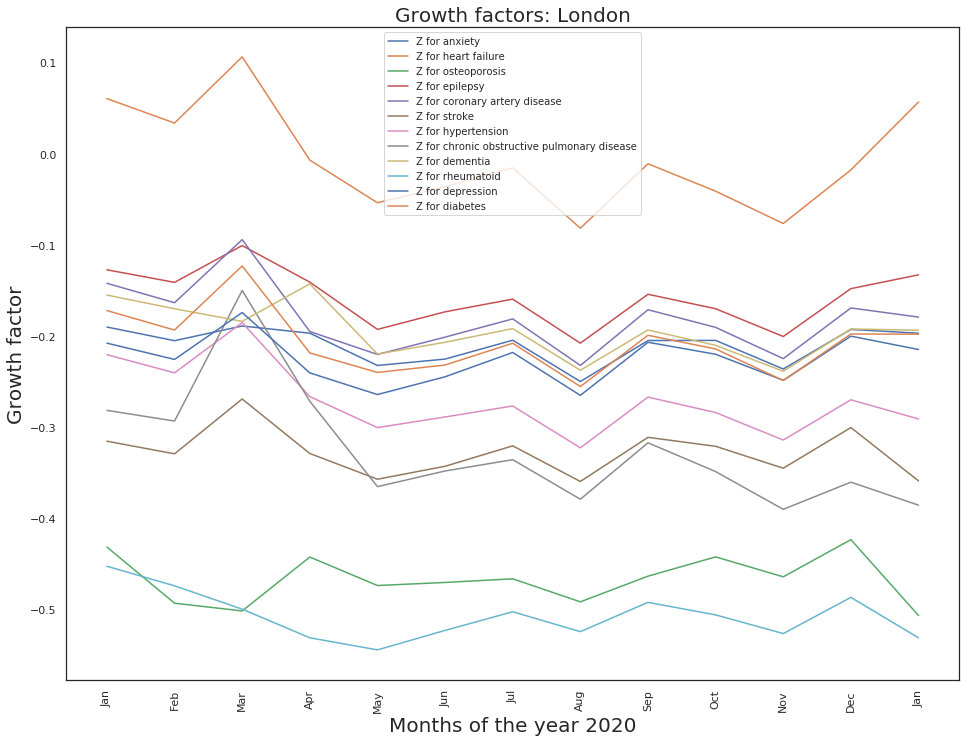

In [258]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
legend = []
for d in diseaseZ_scores:
    sns.lineplot(y=diseaseZ_scores[d][0:13],x=np.arange(0,len(diseaseZ_scores[d]),1))
    legend.append('Z for ' + d)
ax = plt.gca()

plt.xticks(np.arange(0,13,1),month_names,rotation=90)

plt.legend(legend, fontsize = 10)
plt.xlabel("Months of the year 2020",fontsize=20)
plt.ylabel("Growth factor",fontsize=20)
plt.title("Growth factors: " + city, fontsize=20)

In [259]:
from scipy import integrate
import matplotlib.pyplot as plt

y_int = {}
for d in diseaseZ_scores:
    y_int[d] = integrate.cumtrapz(diseaseZ_scores[d][1:-1], np.arange(1,len(diseaseZ_scores[d])-1,1), initial=0)[-1]
print(y_int)

{'anxiety': -2.1456613270535803, 'heart failure': -0.2101965182865232, 'epilepsy': -1.6469438863351198, 'dementia': -2.0086695555939222, 'stroke': -3.273478055729072, 'hypertension': -2.7638556349572267, 'diabetes': -2.1372397648150496, 'chronic obstructive pulmonary disease': -3.235870088754416, 'coronary artery disease': -1.879635545148091, 'rheumatoid': -5.13443544924691, 'depression': -2.298028583483934, 'osteoporosis': -4.678636392329899}


In [253]:
sorted_int = dict(sorted(y_int.items(), key=lambda item: item[1]))

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.]),
 <a list of 7 Text yticklabel objects>)

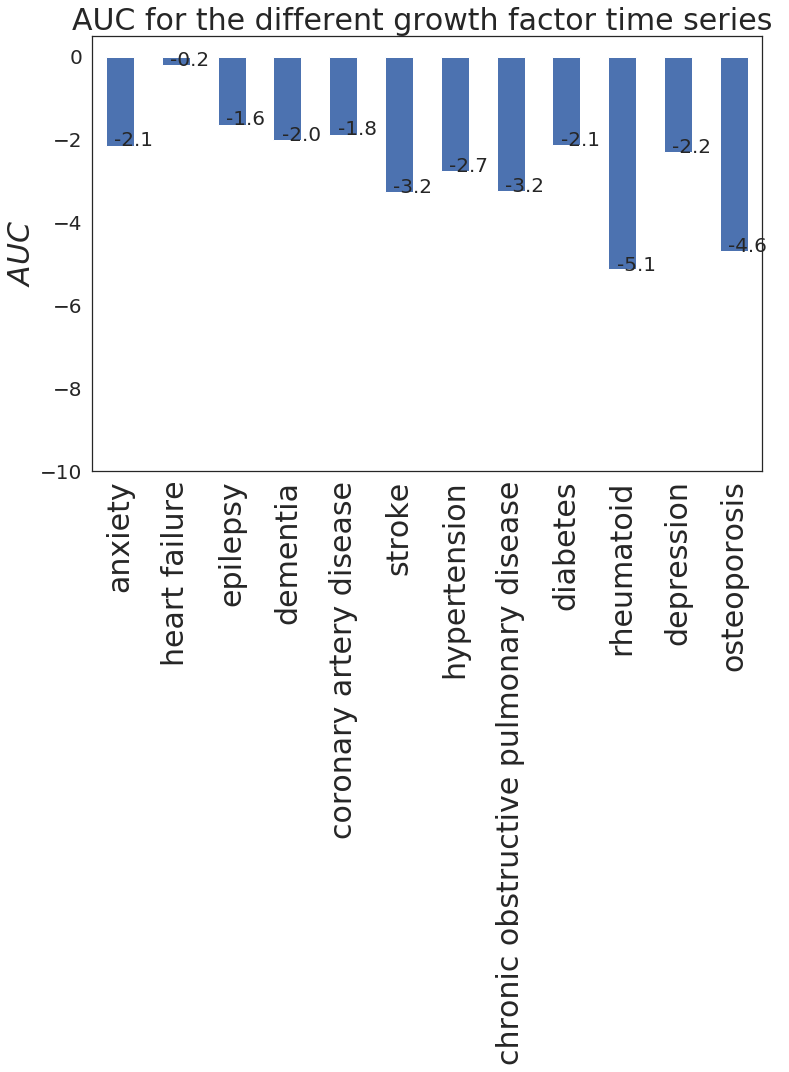

In [260]:
X_labels = sorted_int.keys()
Y = [sorted_int[k] for k in X_labels]
R2_series = pd.Series.from_array(Y)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = R2_series.plot(kind='bar')
plt.grid(False)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() + 0.15 , p.get_height() * 1.005),fontsize = 20)
plt.ylim(-10, 0.5)
# ax.set_title('$R^2$ for crime per capita models',fontsize=30)
ax.set_title('AUC for the different growth factor time series ',fontsize=30)
ax.set_ylabel('$AUC$',fontsize=30)
ax.set_xticklabels(X_labels,fontsize=30)
plt.yticks(fontsize=20)

In [209]:
# monthly_dosage_COVID

In [268]:
city = 'London'

d_l = ['anxiety',
 'heart failure',
 'rheumatoid',
 'epilepsy',
 'dementia',
 'stroke',
 'hypertension',
 'diabetes',
 'chronic obstructive pulmonary disease',
#  'obesity',
 'coronary artery disease',
#  'kidney disease',
 'depression',
 'osteoporosis']

# d_l = ['anxiety' , 'depression']

# all_covid_months = ['201907','201908','201909','201910','201911','201912','202001', '202002', '202003', '202004', '202005', 
#                     '202006', '202007', '202008', '202009', '202010', '202011', '202012','202101','202102',]

all_covid_months = COVID_months
disease_timelines = {}
# months = monthly_dosage_COVID.keys
for disease in d_l:
    disease_timelines[disease] = []
    for month in all_covid_months:
        if city in monthly_dosage_COVID[month][disease]:
            disease_timelines[disease].append(    monthly_dosage_COVID[month][disease][city] )

In [269]:
for d in disease_timelines:
    mean = np.mean(disease_timelines[d])
    std = np.std(disease_timelines[d])
    for i in range(len(disease_timelines[d])):
        disease_timelines[d][i] = (disease_timelines[d][i] - mean)/std

Text(0.5,1,'Prescriptions for city of London')

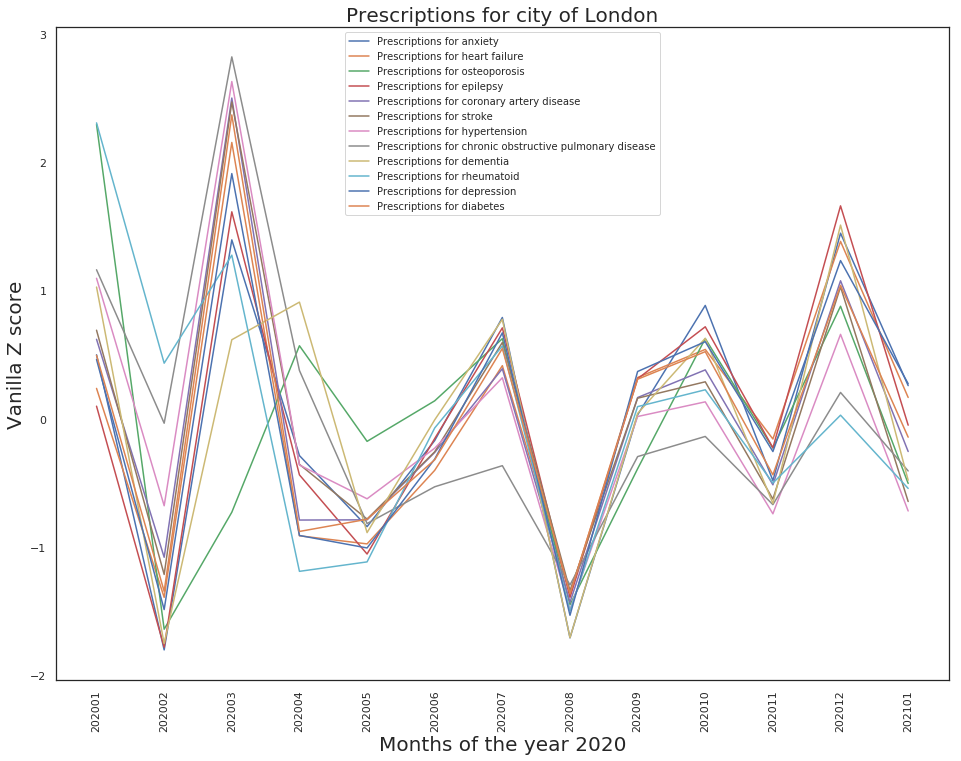

In [270]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
legend = []
for d in disease_timelines:
    sns.lineplot(y=disease_timelines[d],x=np.arange(0,len(disease_timelines[d]),1))
    legend.append('Prescriptions for ' + d)
ax = plt.gca()

plt.xticks(np.arange(0,13,1),COVID_months,rotation=90)

plt.legend(legend, fontsize = 10)
plt.xlabel("Months of the year 2020",fontsize=20)
plt.ylabel("Vanilla Z score",fontsize=20)
plt.title("Prescriptions for city of " + city, fontsize=20)

In [271]:
y_int = {}
for d in disease_timelines:
    y_int[d] = integrate.cumtrapz(disease_timelines[d], np.arange(0,len(disease_timelines[d]),1), initial=0)[-1]
print(y_int)

{'anxiety': -0.37807245054254457, 'heart failure': -0.2006775642890556, 'epilepsy': -0.023122280886560653, 'dementia': -0.2732971935229551, 'stroke': -0.021734811778615415, 'hypertension': -0.18739101413394976, 'diabetes': -0.17486869702379748, 'chronic obstructive pulmonary disease': -0.3768302012992722, 'coronary artery disease': -0.18146792080834329, 'rheumatoid': -0.8818336889926478, 'depression': -0.36710367526112875, 'osteoporosis': -0.8951669203108392}


/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 <a list of 7 Text yticklabel objects>)

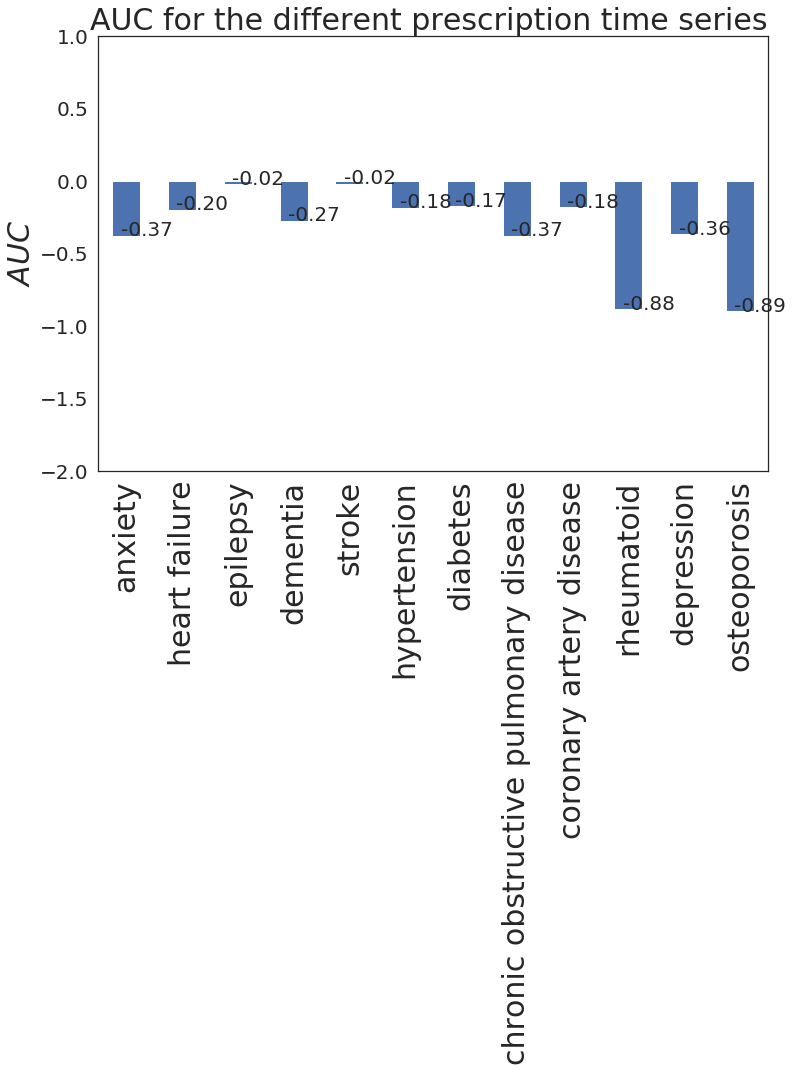

In [272]:
X_labels = y_int.keys()
Y = [y_int[k] for k in X_labels]
R2_series = pd.Series.from_array(Y)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = R2_series.plot(kind='bar')
plt.grid(False)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:5], (p.get_x() + 0.15 , p.get_height() * 1.005),fontsize = 20)
plt.ylim(-2, 1)
# ax.set_title('$R^2$ for crime per capita models',fontsize=30)
ax.set_title('AUC for the different prescription time series ',fontsize=30)
ax.set_ylabel('$AUC$',fontsize=30)
ax.set_xticklabels(X_labels,fontsize=30)
plt.yticks(fontsize=20)

In [273]:
city = 'London'

d_l = ['anxiety',
 'heart failure',
 'rheumatoid',
 'epilepsy',
 'dementia',
 'stroke',
 'hypertension',
 'diabetes',
 'chronic obstructive pulmonary disease',
#  'obesity',
 'coronary artery disease',
#  'kidney disease',
 'depression',
 'osteoporosis']

# d_l = ['anxiety' , 'depression']

# all_covid_months = ['201907','201908','201909','201910','201911','201912','202001', '202002', '202003', '202004', '202005', 
#                     '202006', '202007', '202008', '202009', '202010', '202011', '202012','202101','202102',]

all_covid_months = baseline_months
disease_timelines = {}
# months = monthly_dosage_COVID.keys
for disease in d_l:
    disease_timelines[disease] = []
    for month in all_covid_months:
        if city in monthly_dosage_BL[month][disease]:
            disease_timelines[disease].append(    monthly_dosage_BL[month][disease][city] )

In [274]:
for d in disease_timelines:
    mean = np.mean(disease_timelines[d])
    std = np.std(disease_timelines[d])
    for i in range(len(disease_timelines[d])):
        disease_timelines[d][i] = (disease_timelines[d][i] - mean)/std

Text(0.5,1,'Prescriptions for city of London')

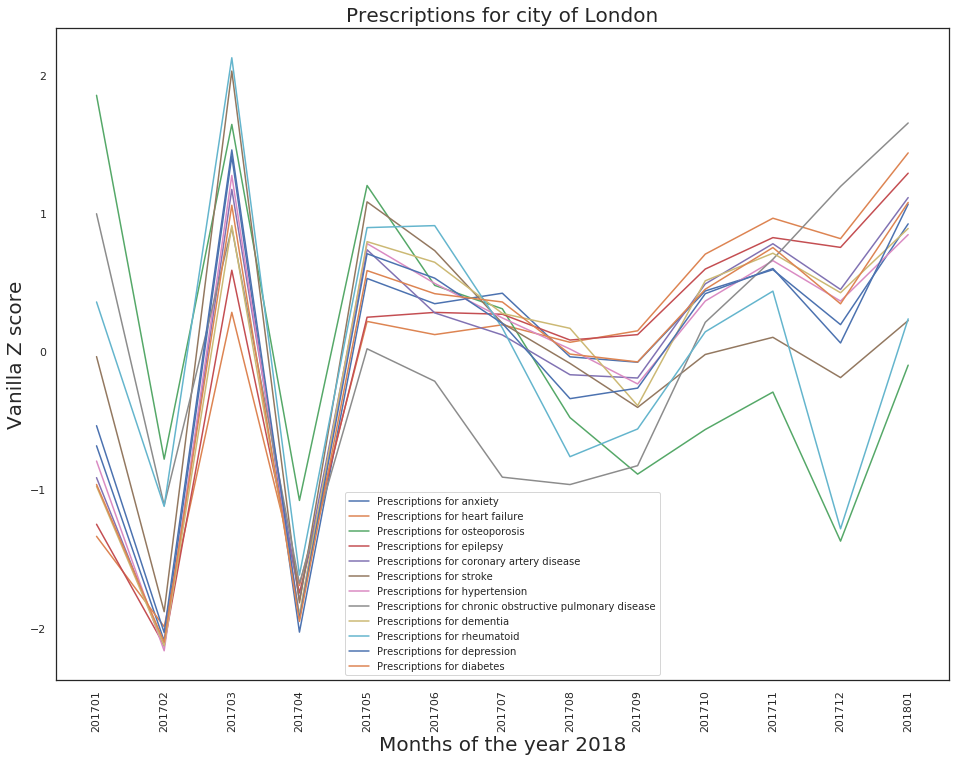

In [275]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
legend = []
for d in disease_timelines:
    sns.lineplot(y=disease_timelines[d],x=np.arange(0,len(disease_timelines[d]),1))
    legend.append('Prescriptions for ' + d)
ax = plt.gca()

plt.xticks(np.arange(0,13,1),all_covid_months,rotation=90)

plt.legend(legend, fontsize = 10)
plt.xlabel("Months of the year 2018",fontsize=20)
plt.ylabel("Vanilla Z score",fontsize=20)
plt.title("Prescriptions for city of " + city, fontsize=20)

In [276]:
y_int_BL = {}
for d in disease_timelines:
    y_int_BL[d] = integrate.cumtrapz(disease_timelines[d], np.arange(0,len(disease_timelines[d]),1), initial=0)[-1]
print(y_int_BL)

{'anxiety': -0.12573487433829889, 'heart failure': -0.05498279055250266, 'epilepsy': -0.025216148318748743, 'dementia': 0.03751400402587757, 'stroke': -0.09852487458021164, 'hypertension': -0.03146870046099848, 'diabetes': -0.06343216718830946, 'chronic obstructive pulmonary disease': -1.330992783377028, 'coronary artery disease': -0.10551185670980101, 'rheumatoid': -0.30255541645988143, 'depression': -0.269766099179677, 'osteoporosis': -0.8830232161038689}


/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 <a list of 7 Text yticklabel objects>)

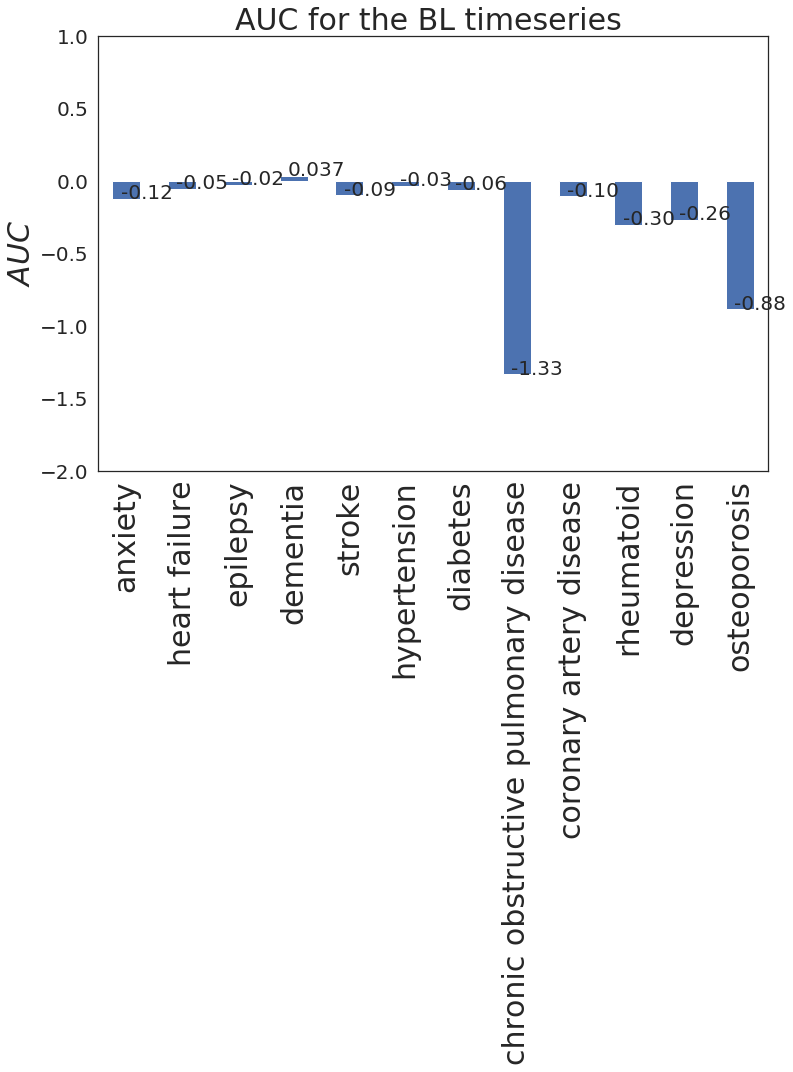

In [277]:
X_labels = y_int.keys()
Y = [y_int_BL[k] for k in X_labels]
R2_series = pd.Series.from_array(Y)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = R2_series.plot(kind='bar')
plt.grid(False)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:5], (p.get_x() + 0.15 , p.get_height() * 1.005),fontsize = 20)
plt.ylim(-2, 1)
# ax.set_title('$R^2$ for crime per capita models',fontsize=30)
ax.set_title('AUC for the BL timeseries ',fontsize=30)
ax.set_ylabel('$AUC$',fontsize=30)
ax.set_xticklabels(X_labels,fontsize=30)
plt.yticks(fontsize=20)

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  """


(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 9 Text yticklabel objects>)

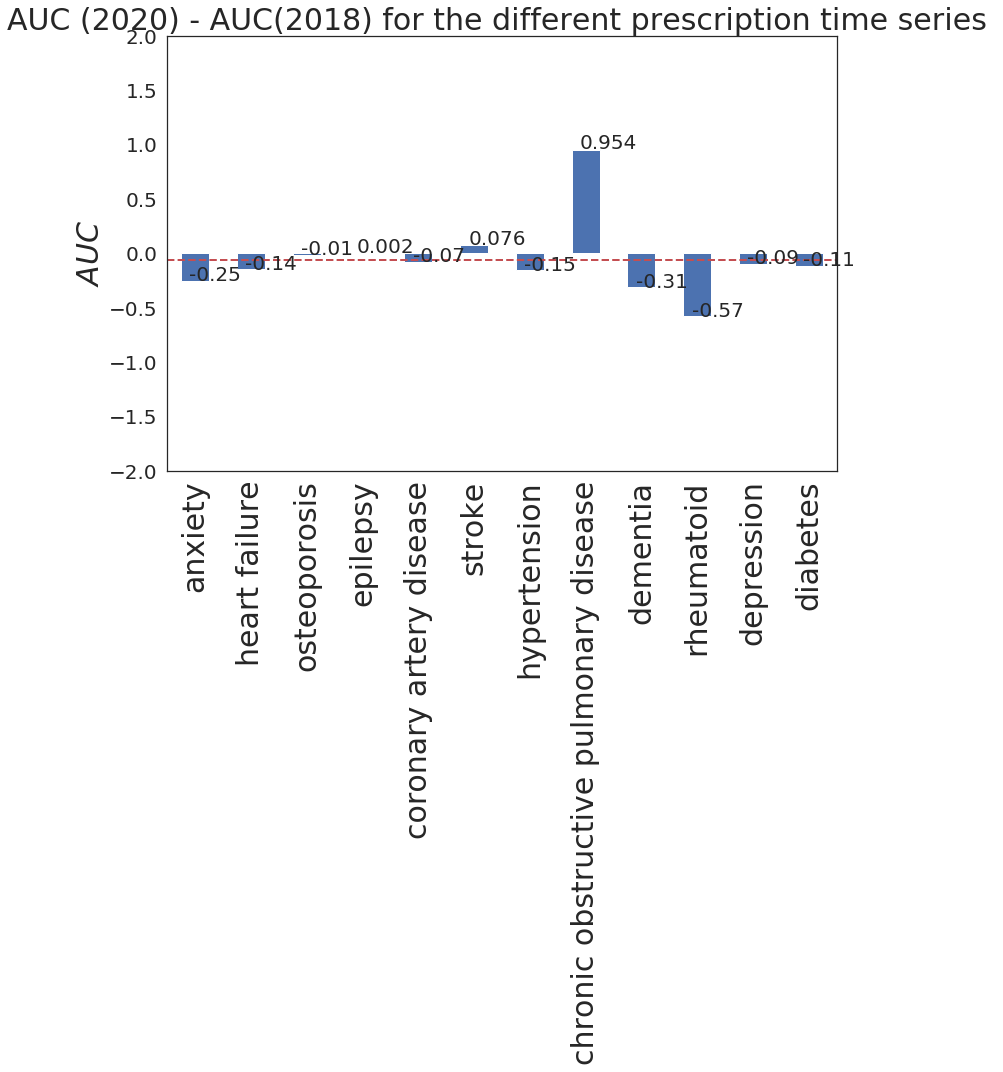

In [283]:
dif_int = {k : y_int[k] - y_int_BL[k] for k in y_int}
mean = np.mean(dif_int.values())
X_labels = dif_int.keys()
Y = [dif_int[k] for k in X_labels]
R2_series = pd.Series.from_array(Y)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = R2_series.plot(kind='bar')
plt.grid(False)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:5], (p.get_x() + 0.15 , p.get_height() * 1.005),fontsize = 20)
plt.ylim(-2, 2)
# ax.set_title('$R^2$ for crime per capita models',fontsize=30)
ax.axhline(mean, linewidth=2, color='r' , linestyle = '--')
ax.set_title('AUC (2020) - AUC(2018) for the different prescription time series ',fontsize=30)
ax.set_ylabel('$AUC$',fontsize=30)
ax.set_xticklabels(X_labels,fontsize=30)
plt.yticks(fontsize=20)